In [493]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [494]:
test = pd.read_csv('C:/Users/user/github/Data/aifactory/test_data.csv')
train = pd.read_csv('C:/Users/user/github/Data/aifactory/train_data.csv')

In [495]:
test.drop('out_pressure',axis=1, inplace=True)
train.drop('out_pressure',axis=1, inplace=True)

In [496]:
te = test.drop(['type'], axis=1)
tr = train.drop(['type'], axis= 1)

In [497]:
ss = StandardScaler()

In [498]:
ss.fit(tr)

StandardScaler()

In [499]:
train_sc = ss.transform(tr)

In [500]:
from sklearn.cluster import DBSCAN

In [501]:
epsilon = 0.3
min_samples = 10
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples).fit(train_sc)

In [502]:
labels = dbscan.fit_predict(train_sc)

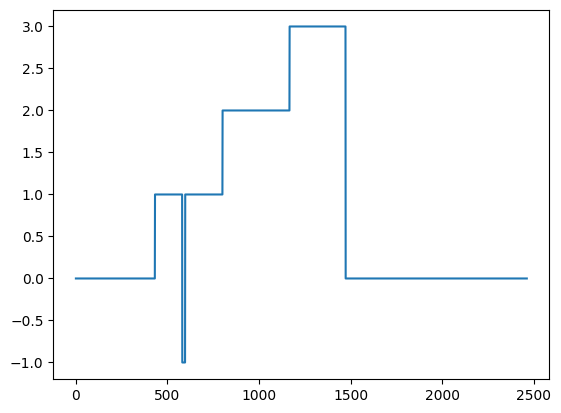

In [503]:
plt.plot(labels)

In [504]:
train_sc = pd.DataFrame(train_sc)

In [505]:
train_sc['label'] = labels

In [506]:
delete = np.where(train_sc['label']== -1)

In [507]:
train_real = train.drop(delete[0], axis=0)

In [508]:
train_real

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...
2458,2.28,50.20,29.53,2416.0,66.84,3.34,7
2459,2.04,46.94,26.34,2155.0,63.94,3.20,7
2460,1.19,35.74,15.39,1259.0,53.99,2.70,7
2461,1.21,36.00,15.64,1280.0,54.22,2.71,7


In [509]:
tr = train_real.drop(['type'], axis= 1)

In [510]:
sc = StandardScaler()

In [511]:
sc.fit(tr)

StandardScaler()

In [512]:
tr_sc = ss.fit_transform(tr)

In [513]:
te_sc = sc.fit_transform(te)

In [514]:
tr_sc = pd.DataFrame(tr_sc)

In [515]:
te_sc = pd.DataFrame(te_sc)

In [516]:
tr_sc

,0,1,2,3,4,5
0,-0.451541,-0.917260,-0.514570,-1.007673,-0.910371,-0.626443
1,0.694479,1.175766,0.796894,1.115975,1.170323,0.636336
2,-0.185797,-0.426063,-0.206336,-0.509444,-0.422228,-0.333848
3,0.196209,0.265506,0.226660,0.192144,0.264504,0.081945
4,-0.194102,-0.435223,-0.212207,-0.518159,-0.431196,-0.333848
...,...,...,...,...,...,...
2442,0.121469,0.136123,0.145932,0.061414,0.136382,0.004947
2443,-0.077839,-0.237141,-0.088179,-0.317705,-0.235170,-0.210650
2444,-0.783721,-1.519520,-0.891790,-1.619203,-1.509979,-0.980636
2445,-0.767112,-1.489751,-0.873443,-1.588699,-1.480511,-0.965237


---
#### 공분산에는 scale 개념이 있어 공분산을 사용하는 GMM, BGM, CBM에는 scale한 데이터를 사용하지 않음
#### 나머지 데이터는 scale한 데이터 사용하여 fitting

#### tr과 te // tr_sc와 te_sc 사용

In [517]:
result = pd.DataFrame(index = test.index ,columns=['gm','bgm','LOF','autoencoder', 'CBM'], data=0)

In [518]:
from sklearn.mixture import GaussianMixture

# GMM: n_components = 모델의 총 수
gm = GaussianMixture(n_components=4, covariance_type = 'full',n_init=30, random_state=42)
gm.fit(tr)

GaussianMixture(n_components=4, n_init=30, random_state=42)

In [519]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=4, n_init=15, random_state=42)
bgm.fit(tr)

BayesianGaussianMixture(n_components=4, n_init=15, random_state=42)

In [520]:
print(gm.converged_)
print(bgm.converged_)

True
True


In [521]:
densities = gm.score_samples(te)
density_threshold = np.percentile(densities, 5)

bgm_densities = bgm.score_samples(te)
bgm_density_threshold = np.percentile(bgm_densities, 5)

Text(0.5, 1.0, 'gmm result')

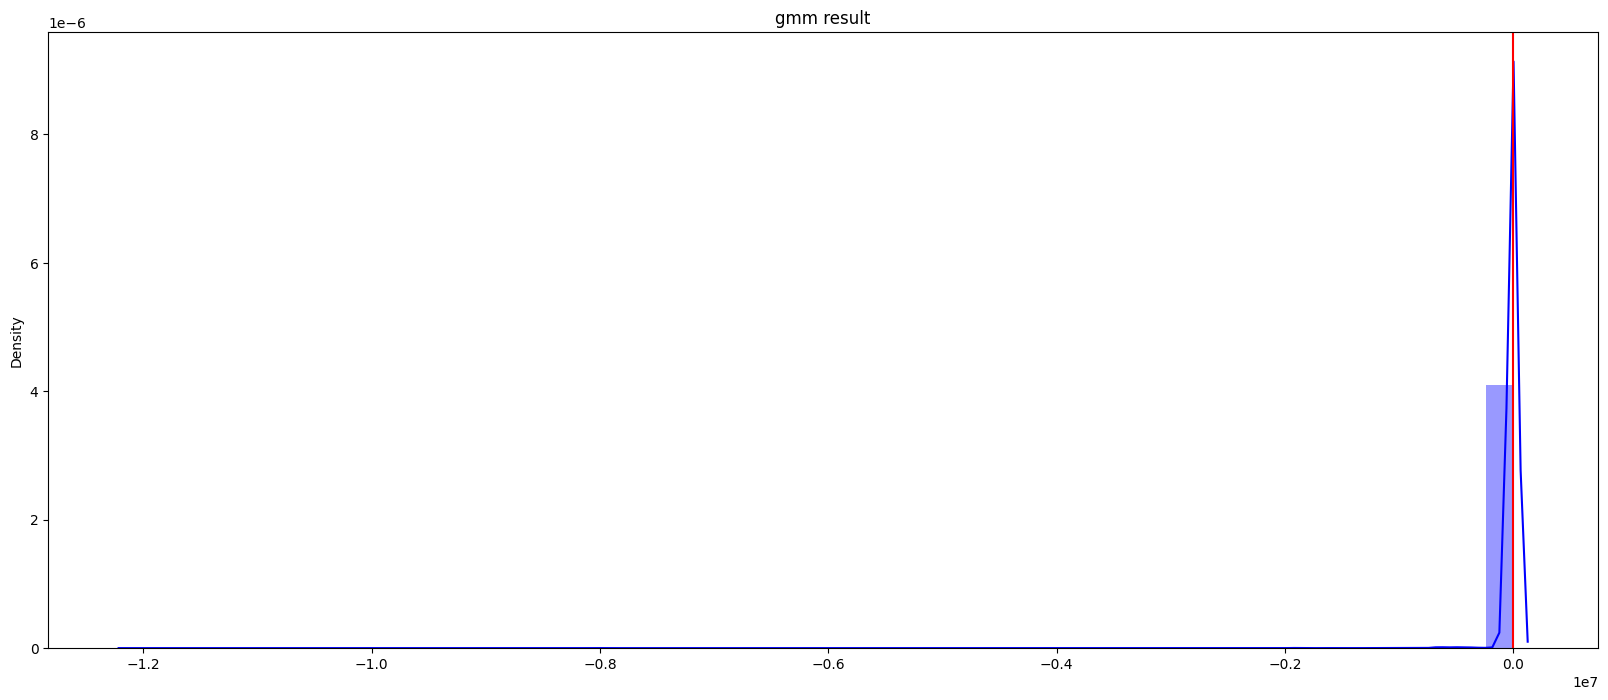

In [522]:
plt.figure(figsize=(20,8))
sns.distplot(densities, kde=True, color="b")
plt.axvline(density_threshold, color = 'red')
plt.title('gmm result')

Text(0.5, 1.0, 'bgm result')

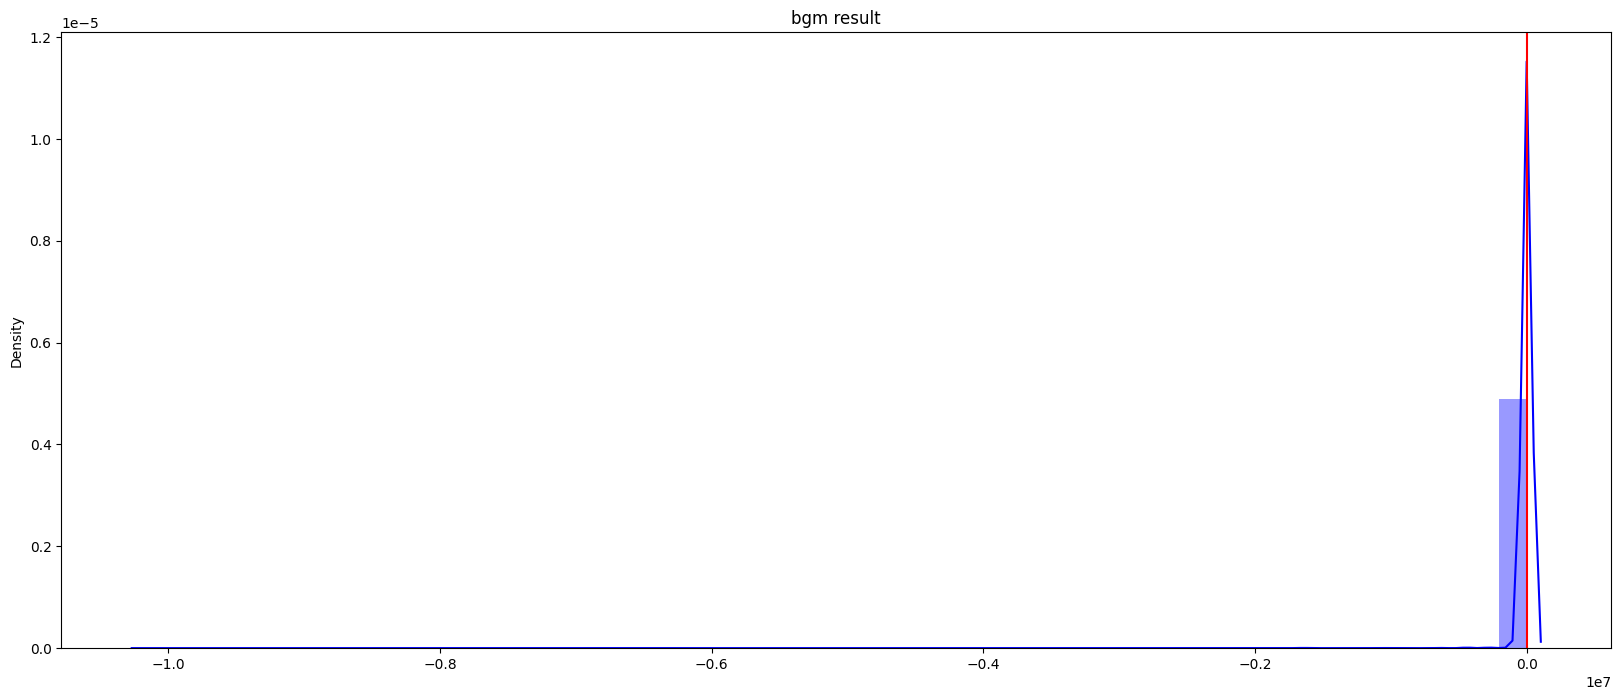

In [523]:
plt.figure(figsize=(20,8))
sns.distplot(bgm_densities, kde=True, color="b")
plt.axvline(bgm_density_threshold, color = 'red')
plt.title('bgm result')

In [524]:
anomalies = te[densities < density_threshold]

bgm_anomalies = te[bgm_densities < bgm_density_threshold]

In [525]:
result.loc[anomalies.index.tolist(), 'gm'] = 1
result.loc[bgm_anomalies.index.tolist(), 'bgm'] = 1

---
## LOF

In [526]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV

In [527]:
clf = LocalOutlierFactor()

In [528]:
param_grid = {'n_neighbors' : [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28], 'contamination' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],}

In [529]:
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid,
                           scoring='accuracy', 
                           n_jobs=-1, 
                           verbose=2
                          )

In [530]:
grid_search.fit(tr_sc)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(estimator=LocalOutlierFactor(), n_jobs=-1,
             param_grid={'contamination': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                           0.8, 0.9],
                         'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                         26, 27, 28]},
             scoring='accuracy', verbose=2)

In [531]:
best_param = grid_search.best_params_

In [532]:
best_param

{'contamination': 0.1, 'n_neighbors': 5}

In [533]:
clf2 = LocalOutlierFactor(**best_param)

In [534]:
clf2.fit(tr_sc)

LocalOutlierFactor(contamination=0.1, n_neighbors=5)

#### LOF 비지도학습 알고리즘이라 학습할 필요없이 그냥 바로 fit_predict 해도 될듯?

In [535]:
clf2.fit_predict(te_sc)

array([-1,  1,  1, ...,  1,  1,  1])

In [536]:
lof_score = clf2.negative_outlier_factor_

In [537]:
lof_threshold = np.percentile(lof_score, 3)

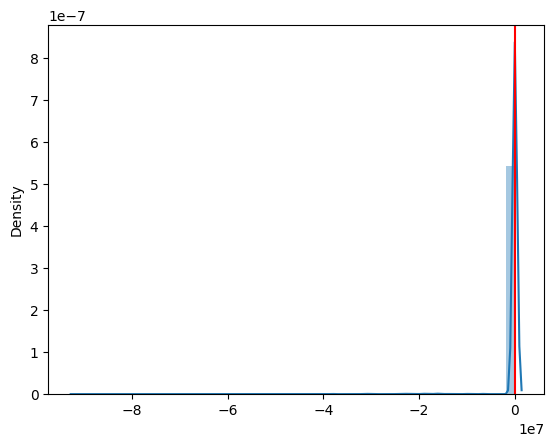

In [538]:
sns.distplot(lof_score)
plt.axvline(lof_threshold, color = 'r')
plt.show()

In [539]:
result.loc[np.where(lof_score<lof_threshold)[0], 'LOF'] = 1

---

## AutoEncoder

In [540]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [541]:
input_dim = tr_sc.shape[1]

input_layer = Input(shape=(input_dim,))
encoder = Dense(32, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)

autoencoder = Model(input_layer, decoder)
autoencoder.compile(optimizer='adam', loss='mse')

In [542]:
autoencoder.fit(tr_sc, tr_sc, epochs=500, batch_size=100, shuffle=True)

Epoch 1/500
25/25 [==============================] - 0s 583us/step - loss: 0.8032
Epoch 2/500
25/25 [==============================] - 0s 500us/step - loss: 0.7273
Epoch 3/500
25/25 [==============================] - 0s 542us/step - loss: 0.6952
Epoch 4/500
25/25 [==============================] - 0s 542us/step - loss: 0.6791
Epoch 5/500
25/25 [==============================] - 0s 542us/step - loss: 0.6668
Epoch 6/500
25/25 [==============================] - 0s 542us/step - loss: 0.6587
Epoch 7/500
25/25 [==============================] - 0s 583us/step - loss: 0.6544
Epoch 8/500
25/25 [==============================] - 0s 542us/step - loss: 0.6525
Epoch 9/500
25/25 [==============================] - 0s 542us/step - loss: 0.6518
Epoch 10/500
25/25 [==============================] - 0s 542us/step - loss: 0.6514
Epoch 11/500
25/25 [==============================] - 0s 500us/step - loss: 0.6512
Epoch 12/500
25/25 [==============================] - 0s 583us/step - loss: 0.6510
Epoch 13/500


In [543]:
x_pred = autoencoder.predict(te_sc)
mse = np.mean(np.power(te_sc - x_pred, 2), axis=1)

231/231 [==============================] - 0s 428us/step


In [544]:
# 이상치 검출
auto_threshold = np.mean(mse) + 3*np.std(mse)
auto_outliers = np.where(mse > auto_threshold)[0]

In [545]:
auto_threshold

2.9719749879245922

In [546]:
auto_outliers

array([2406, 2413, 2416, 2418, 2420, 2425, 2455, 2468, 2478, 2479, 2488,
       2492, 2518, 2529, 2541, 2573, 2575, 2594, 2612, 2624, 2637, 2668,
       2691, 2697, 2716, 2736, 2739, 2750, 2758, 2764, 2768, 2781, 2782,
       2793, 2805, 2817, 2825, 2836, 2853, 2888, 2918, 2935, 2940, 2946,
       2972, 2980, 2986, 2987, 3007, 3094, 3109, 3112, 3142, 3143, 3170,
       3185, 3211, 3269, 3299, 3316, 3322, 3341, 3368, 3417, 3500, 3503,
       3507, 3509, 3510, 3520, 3522, 3529, 3536, 3542, 3543, 3553, 3557,
       3559, 3571, 3572, 3574, 3591, 3605, 3614, 3616, 3625, 3636, 3646,
       3647, 3648, 3650, 3651, 3654, 3661, 3668, 3670, 3684, 3689, 3697,
       3706, 3707, 3710, 3716, 3722, 3747, 3748, 3757, 3764, 3768, 3772,
       3775, 3781, 3787, 3790, 3794, 3802, 3820, 3821, 3822, 3823, 3830,
       3832, 3836, 3839, 3843, 3858, 3866, 3867, 3871, 3880, 3888, 3896,
       3897, 3923, 3935, 3942, 3950, 3958, 3967, 3986, 3995, 4008, 4012,
       4025, 4039, 4043, 4047, 4048, 4051, 4055, 40

In [547]:
result.loc[auto_outliers, 'autoencoder'] = 1

---
## CBM

In [548]:
def hotellings_tsquare(trdat, tedat):
    '''
    Hotellings T-square : 공분산을 반영한 유클리디안 거리 (마할라노비스 거리)
    
    @param trdat : train data
    @param tedat : test data
    '''
    obs = trdat.shape[0]
    dim = trdat.shape[1]
    
    mu = trdat.apply(np.mean, axis=0) # 열단위 평균계산
    sinv = np.linalg.pinv(trdat.cov()) # 공분산 역행렬

    dte = (tedat-mu).values 
    
    Tsq_mat = np.zeros(tedat.shape[0])
    for i in range(tedat.shape[0]):
        Tsq_mat[i] = dte[i,:] @ sinv @ dte[i,:].transpose() # t-square distance
        
    return Tsq_mat

def bootstrap_limit(stat, alpha=0.05, bootstrap=300):
    '''
    Bootstrap sampling을 활용한 Control Limit 산출 기법
    
    @param stat : 통계량
    @param alpha : Control Limit을 정하기 위한 유의수준
    @param : bootstrap : 샘플링 횟수
    '''
    alpha = (alpha/2)*100
    alpha = 100 - alpha
    samsize = max(10000, len(stat))
    limit = np.mean(list(map(lambda x:np.percentile(np.random.choice(stat,samsize,replace=True),alpha), range(0,bootstrap))))
    # stat에서 samsize만큼 선택 후 75%분위수(alpha에따라 변경) 뽑기 이후 bootstrap만큼 반복 후 리스트로 만들고 평균 계산
    return limit

In [549]:
hotell_result = []
for i in range(4):
    data = train_sc[train_sc['label'] == i]
    hotell_result.append(hotellings_tsquare(data,train_sc))

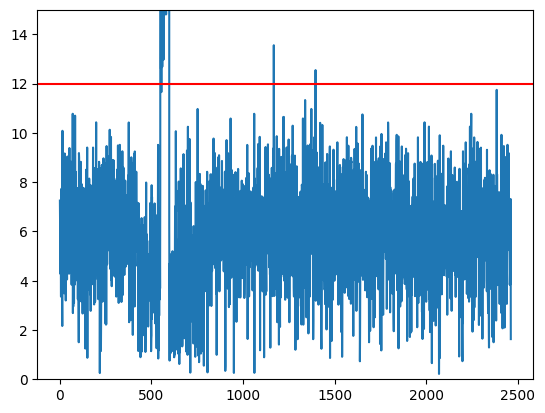

In [550]:
pd.DataFrame(hotell_result).T.min(axis=1).plot()
plt.ylim(0,15)
plt.axhline(12,color='r')
plt.show()

In [551]:
drop_index = np.where(pd.DataFrame(hotell_result).T.min(axis=1) < 12)

In [552]:
real_tr = tr.loc[drop_index]

In [553]:
real_label = pd.DataFrame(labels).loc[drop_index]

In [554]:
real_tr['label'] = real_label

In [555]:
hotell_result = []
for i in range(4):
    data = real_tr[real_tr['label'] == i]
    drop_data = data.drop(['label'], axis=1)
    hotell_result.append(hotellings_tsquare(drop_data,real_tr.drop('label',axis=1)))

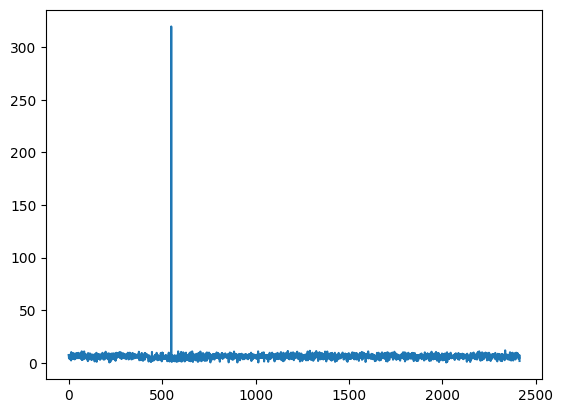

In [556]:
pd.DataFrame(hotell_result).T.min(axis=1).plot()
plt.show()

In [557]:
hotell_result_te = []
for i in range(4):
    data = real_tr[real_tr['label'] == i]
    drop_data = data.drop('label', axis=1)
    hotell_result_te.append(hotellings_tsquare(drop_data,test.drop('type', axis=1)))

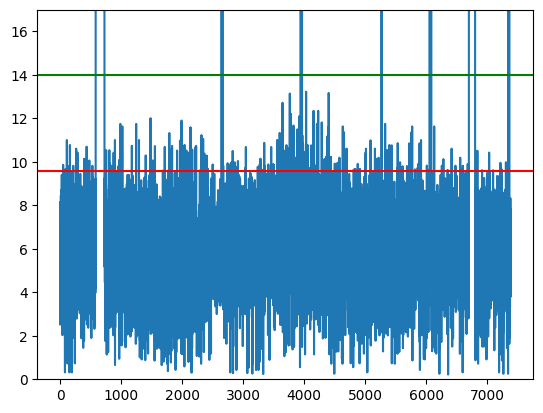

In [558]:
pd.DataFrame(hotell_result_te).T.min(axis=1).plot()
plt.axhline(bootstrap_limit(pd.DataFrame(hotell_result).T.min(axis=1)), color ='r')
plt.axhline(14, color='green')
plt.ylim(0,17)
plt.show()

In [559]:
total_result = pd.DataFrame(hotell_result_te).T.min(axis=1)

In [560]:
control_limit = np.where(total_result >14)[0]

In [561]:
result.loc[control_limit, 'CBM'] = 1

In [562]:
result['label'] = 0

In [563]:
result

,gm,bgm,LOF,autoencoder,CBM,label
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,1,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
7384,0,0,0,0,0,0
7385,0,0,0,0,0,0
7386,0,0,0,0,0,0
7387,0,0,0,0,0,0


In [564]:
print(result.gm.value_counts())
print('---')
print(result.bgm.value_counts())
print('---')
print(result.LOF.value_counts())
print('---')
print(result.autoencoder.value_counts())
print('---')
print(result.CBM.value_counts())

0    7019
1     370
Name: gm, dtype: int64
---
0    7019
1     370
Name: bgm, dtype: int64
---
0    7168
1     221
Name: LOF, dtype: int64
---
0    7198
1     191
Name: autoencoder, dtype: int64
---
0    7052
1     337
Name: CBM, dtype: int64


<Axes: >

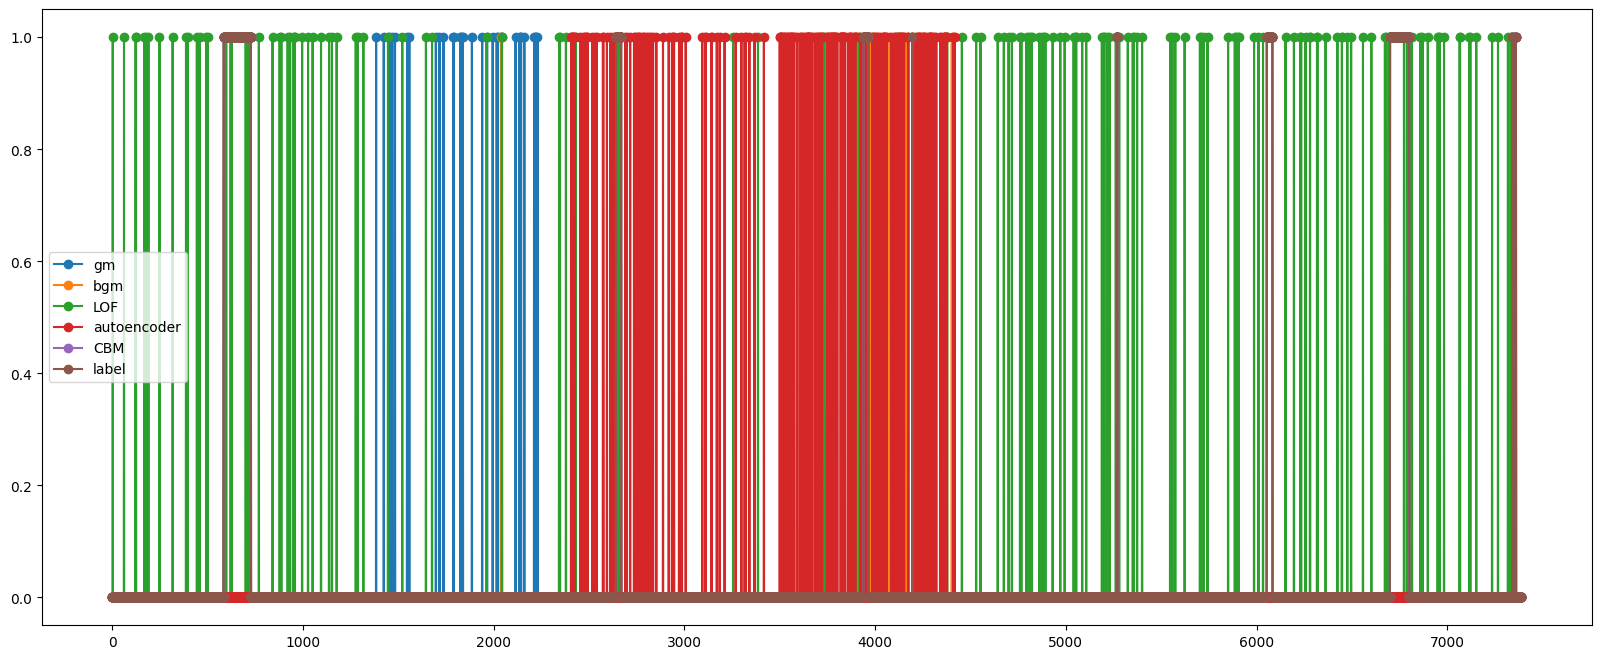

In [590]:
result.plot(figsize=(20,8), marker = "o")

In [565]:
result.iloc[:,:3].mean(axis=1)[10]

0.0

In [566]:
for i in range(len(result)):
    if result.iloc[:,4][i] == 1:
        result.label[i] = 1
    elif result.iloc[:,:3].mean(axis=1)[i] >= 0.5:
        result.label[i] = 1
    else:
        pass

<Axes: >

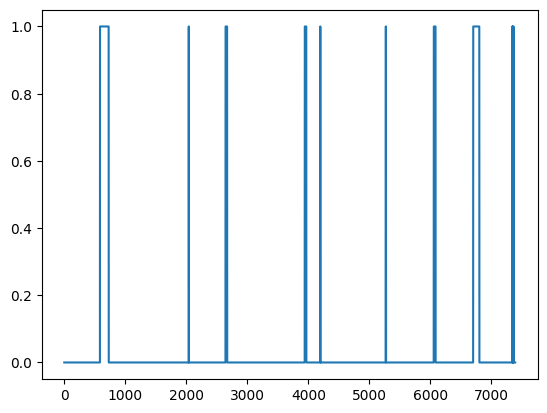

In [567]:
result.label.plot()

In [568]:
result.label.value_counts()

0    7050
1     339
Name: label, dtype: int64

In [574]:
result.label = 0

In [575]:
result

,gm,bgm,LOF,autoencoder,CBM,label
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,1,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
7384,0,0,0,0,0,0
7385,0,0,0,0,0,0
7386,0,0,0,0,0,0
7387,0,0,0,0,0,0


In [578]:
result.label = result.iloc[:,:5].mean(axis=1)
for i in range(len(result)):
    if result.label[i] > 0.5:
        result.label[i] = 1
    else:
        result.label[i] = 0

<Axes: >

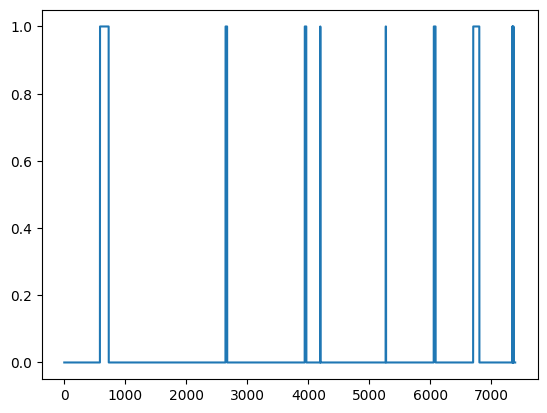

In [579]:
result.label.plot()

In [580]:
result.label.value_counts()

0.0    7051
1.0     338
Name: label, dtype: int64

In [581]:
result.to_csv('C:/Users/user/Desktop/re.csv', index=False)